# Working with `pandas` Data Frames
## Abstract
The report demonstrates how to use `pandas` to join and analyse multiple datasets from the 2017 `myki` tram records. By combining touch-on, touch-off, and stop location data, we construct complete passenger journey and apply aggregation techniques to extract insights. The analysis identifies the top 10 busiest stops, the busiest tram routes, and the longest routes based on average end-to-end travel time. Through these examples, the report illustrates how effective data joining and summarization with `pandas` enables meaningful interpretation of transport usage patterns.

## Demonstration
### 1. Prepare Data
In this section, we will load dataset from three different data files.

In [1]:
import pandas as pd

# Read CSV files
scanOnTransactions = pd.read_csv('data/myki/myki_2017_top20_tram_routes_ScanOnTransaction.csv')

scanOffTransactions = pd.read_csv('data/myki/myki_2017_top20_tram_routes_ScanOffTransaction.csv')

By comparing the stop information with [Yarra Trams’ official route guides](https://yarratrams.com.au/route-guides) and verifying locations in [Google Maps](https://www.google.com/), we determined that the stop data is delimited by `|` and follows the field order: StopID, StopNameShort, StopNameLong, StopType, Suburb, Postcode, City, LGA, Region, Latitude, and Longitude.

In [2]:
# Read TXT file
stops = pd.read_csv("data/myki/stop_locations.txt", sep="|", names=[
    "StopID",
    "StopNameShort",
    "StopNameLong",
    "StopType",
    "Suburb",
    "Postcode",
    "City",
    "LGA",
    "Region",
    "Latitude",
    "Longitude"
])

After loading the datasets, the next step is to link each transaction with its corresponding stop details to provide meaningful context for both touch-on and touch-off events.

In [3]:
scanOnTransactions = scanOnTransactions.merge(
    stops[["StopID", "StopNameLong"]],
    left_on="stop_id",
    right_on="StopID",
    how="left"
).rename(columns={
    "StopID": "StopNumber_on",
    "StopNameLong": "StopNameLong_on"
})


In [4]:
scanOffTransactions = scanOffTransactions.merge(
    stops[["StopID", "StopNameLong"]],
    left_on="stop_id",
    right_on="StopID",
    how="left"
).rename(columns={
    "StopID": "StopNumber_off",
    "StopNameLong": "StopNameLong_off"
})

At this stage, we have complete records for both passenger touch-on and touch-off events. By joining the datasets using `card_id`, `business_date`, `route_id`, and `vehicle_id`, we can identify when a passenger (card_id) travelled (business_date), which route they used (route_id), which vehicle they boarded (vehicle_id), as well as the specific stops where they touched on and touched off.

In [5]:
merged = scanOnTransactions.merge(
    scanOffTransactions,
    on=["card_id", "business_date", "route_id", "vehicle_id"],
    how="left",
    suffixes=("_on", "_off")  # avoid name collision
)

final = merged[["business_date", "card_id", "route_id", "vehicle_id", "stop_id_on", "date_time_on", "StopNameLong_on",
                "stop_id_off", "date_time_off", "StopNameLong_off"]]

### 2. Identify top 10 busiest stops
In this section, we identify the top 10 busiest stops based on the yearly average number of touch-on transactions. To begin, we group the data by `stop_id_on` and `StopNameLong_on` to calculate the total number of touch-on events at each stop.

In [6]:
touch_on_counts = (
    final.groupby(["stop_id_on", "StopNameLong_on"])
    .size()
    .reset_index(name="touch_on_count")
    .sort_values("touch_on_count", ascending=False)
)

top10 = touch_on_counts.head(10)

Using bar chart to show the top 10 busiest stops, order by stops numbers descend.

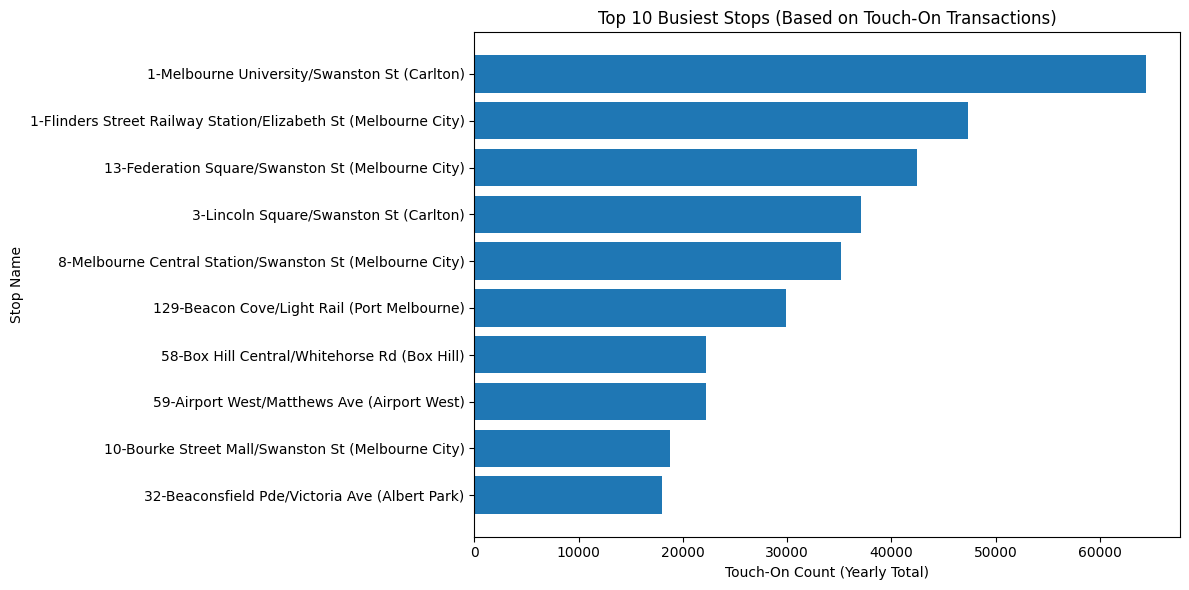

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(top10["StopNameLong_on"], top10["touch_on_count"])
plt.xlabel("Touch-On Count (Yearly Total)")
plt.ylabel("Stop Name")
plt.title("Top 10 Busiest Stops (Based on Touch-On Transactions)")
plt.gca().invert_yaxis()  # Largest at top
plt.tight_layout()
plt.show()

From the figure, we can see that the busiest stop is `1-Melbourne University/Swanston St (Carlton)`, which 
touch_on_count is around 64000. 

### 3. Identify the top 10 busiest tram routes
In this section, we identify the top 10 busiest tram routes based on the yearly average number of passengers per day, calculate the average number of touch-ons per hour across all days, and use the identified peak windows to determine the average number of touch-ons during the morning and afternoon peak periods for each route.
1. Identify the top 10 busiest tram routes.
2. Calculate the average hourly touch-on counts for these routes.
3. Use the peak windows to compute the average number of touch-ons during the morning and afternoon peaks.

We begin by counting the total number of passengers for each tram route on each day.

In [8]:
daily_counts = (
    final.groupby(["route_id", "business_date"])
    .size()
    .reset_index(name="daily_passengers")
)

Based on this daily passenger dataset, we then calculate the yearly average number of passengers per day for each tram route. Then, sort the dataset.

In [9]:
route_avg = (
    daily_counts.groupby("route_id")["daily_passengers"]
    .mean()
    .reset_index(name="avg_passengers_per_day")
)

In [10]:
top10_routes = route_avg.sort_values(
    "avg_passengers_per_day", ascending=False
).head(10)

A bar chart is used to display the top 10 busiest tram routes, ordered in descending order of average passengers per day.

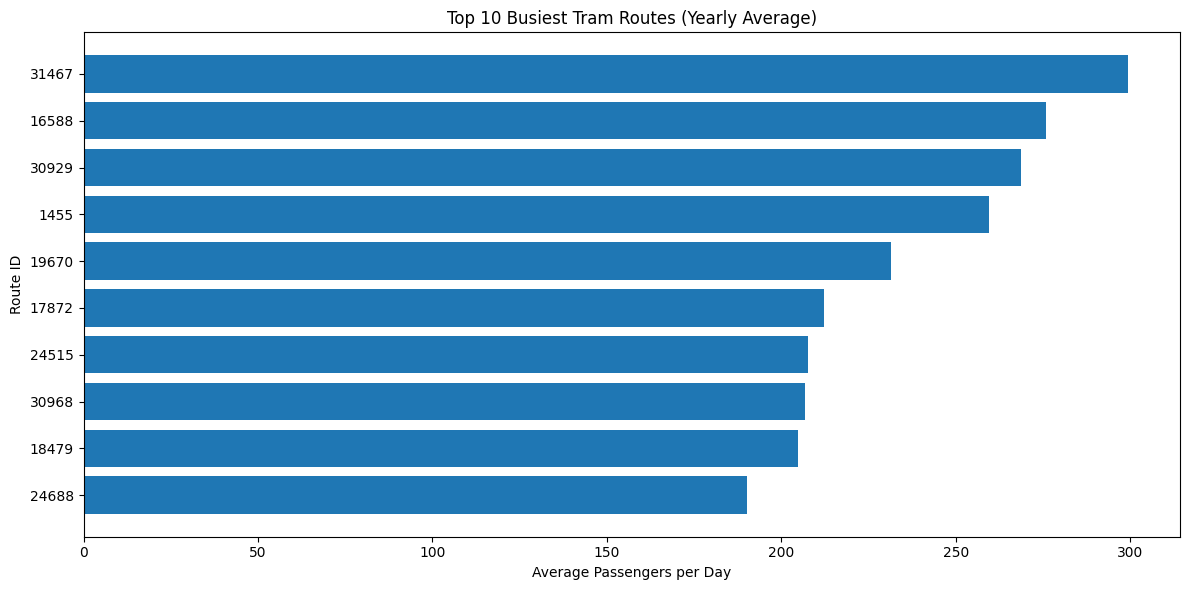

In [11]:
plt.figure(figsize=(12, 6))
plt.barh(
    top10_routes["route_id"].astype(str),
    top10_routes["avg_passengers_per_day"]
)

plt.xlabel("Average Passengers per Day")
plt.ylabel("Route ID")
plt.title("Top 10 Busiest Tram Routes (Yearly Average)")
plt.gca().invert_yaxis()  # largest at top
plt.tight_layout()
plt.show()

From the figure, we can see that the busiest tram route is `31467`, and the average passengers per day is around 300.

#### Calculate the average hourly touch-on counts for these routes
Add a new column to the dataset that extracts the hour of the day from each touch-on timestamp.

In [12]:
df = final.copy()

# convert to datetime
df["date_time_on"] = pd.to_datetime(df["date_time_on"])

# extract hour (0–23)
df["hour"] = df["date_time_on"].dt.hour

hourly_counts = (
    df.groupby(["route_id", "business_date", "hour"])
    .size()
    .reset_index(name="touch_on_count")
)

Calculate the average number of touch-on per hour across all days.

In [13]:
avg_hourly_route = (
    hourly_counts.groupby(["route_id", "hour"])["touch_on_count"]
    .mean()
    .reset_index(name="avg_touch_ons")
)

Plot the results in a line graph with hour of day on the x-axis and average touch-ons on the y-axis with one line per route.

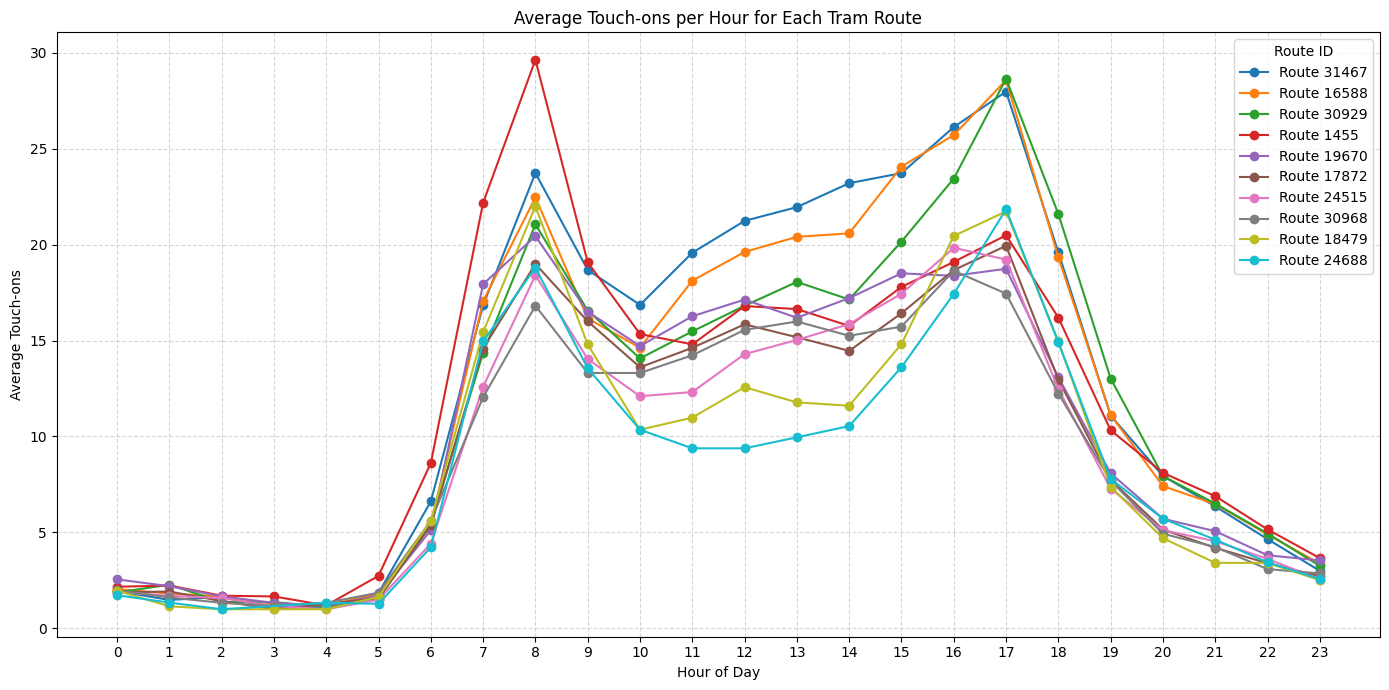

In [14]:
plt.figure(figsize=(14, 7))

for route in top10_routes["route_id"]:
    subset = avg_hourly_route[avg_hourly_route["route_id"] == route]
    plt.plot(subset["hour"], subset["avg_touch_ons"], marker="o", label=f"Route {route}")

plt.xlabel("Hour of Day")
plt.ylabel("Average Touch-ons")
plt.title("Average Touch-ons per Hour for Each Tram Route")
plt.xticks(range(0, 24))
plt.legend(title="Route ID")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

From this line chart, we can identify the approximate morning peak windows is from 7 to 9 hour and the approximate afternoon peak windows is from 16 to 18,

#### Use the peak windows to compute the average number of touch-ons
Based on the peak windows identified in the figure, we calculated the average number of touch-ons during the morning peak and the afternoon peak, and then derived the average daily touch-on count. 

In [15]:
# average number of touch-ons in the morning peak
morning = hourly_counts[hourly_counts["hour"].isin([7, 8, 9])]
avg_morning = (
    morning.groupby("route_id")["touch_on_count"]
    .mean()
    .reset_index(name="avg_morning_touch_ons")
)

# average number of touch-ons in the afternoon peak
afternoon = hourly_counts[hourly_counts["hour"].isin([16, 17, 18])]
avg_afternoon = (
    afternoon.groupby("route_id")["touch_on_count"]
    .mean()
    .reset_index(name="avg_afternoon_touch_ons")
)

In [16]:
route_peaks = avg_morning.merge(
    avg_afternoon,
    on="route_id",
    how="outer"
).fillna(0)

route_peaks["avg_daily_touch_ons"] = (
    route_peaks[["avg_morning_touch_ons", "avg_afternoon_touch_ons"]].mean(axis=1)
)

Using bar chart to show the daily average touch-ons

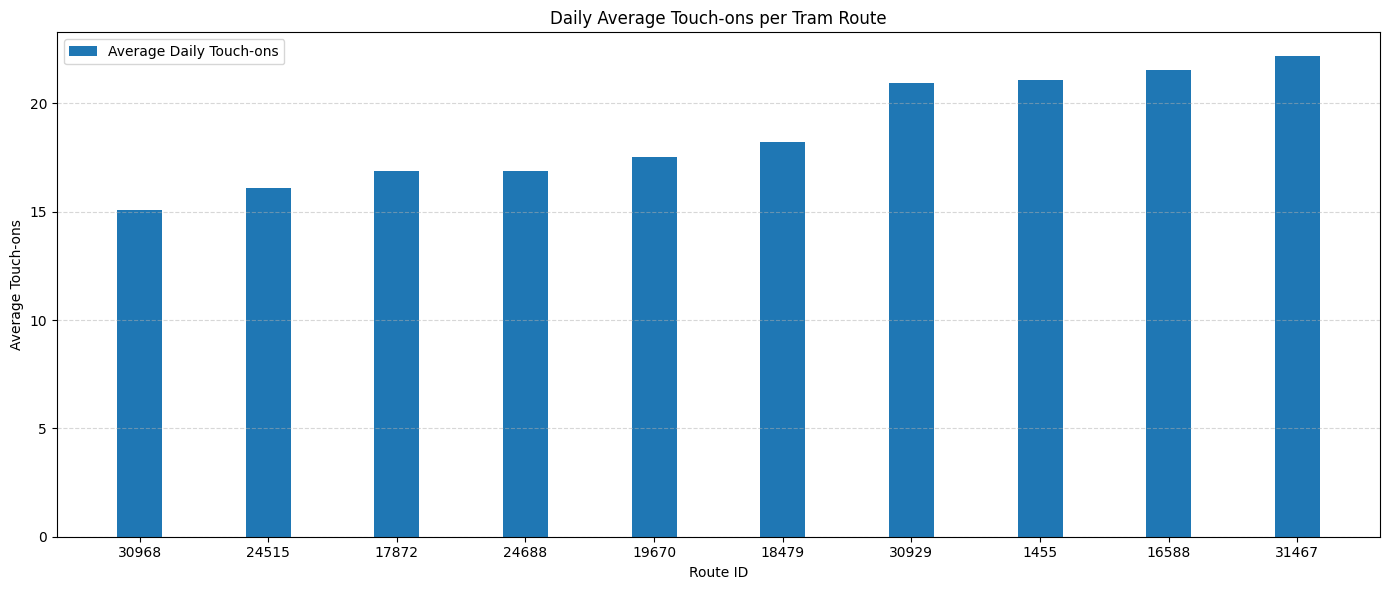

In [17]:
import numpy as np

plot_data = route_peaks[route_peaks["route_id"].isin(top10_routes["route_id"])]
plot_data = plot_data.sort_values("avg_daily_touch_ons")

routes = plot_data["route_id"].astype(str).values
x = np.arange(len(routes))

width = 0.35
plt.figure(figsize=(14, 6))

# average daily difference
plt.bar(
    x,
    plot_data["avg_daily_touch_ons"],
    width,
    label="Average Daily Touch-ons",
)

plt.xticks(x, routes)
plt.xlabel("Route ID")
plt.ylabel("Average Touch-ons")
plt.title("Daily Average Touch-ons per Tram Route")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

From the bar chart, we can see that route 31467 has the highest daily average touch-ons, while route 30968 has the lowest. Routes 19670 and 18479 fall in the middle range. 

### 4. Identify top 10 longest tram routes
At this part, we will identify the top 10 longest tram route base on the average end-to-end travel time over all 
trip, then we will calculate the average number of touch-ons per hour across all day of the route and use the 
identified peak windows to determine the average number of touch-ons during the morning and afternoon peak periods 
for each route.
1. Identify the top 10 longest tram routes.
2. Calculate the average hourly touch-on counts for these routes.
3. Use the peak windows to compute the average number of touch-ons during the morning and afternoon peaks.

First, we need to prepare the data. Since we are calculating the average end-to-end travel time, we must handle any 
records where `stop_id_off` is not a valid number, in this time, I will replace the `date_time_off` with 
`date_time_on` whose `stop_id_off` is nan. Next, we 
compute the travel time
 in minutes by 
subtracting 
`date_time_on` from `date_time_off`.

In [18]:
# clean data set
clean = final.copy()

clean["date_time_on"] = pd.to_datetime(clean["date_time_on"])
clean["date_time_off"] = pd.to_datetime(clean["date_time_off"], errors="coerce")
clean["date_time_off"] = clean["date_time_off"].fillna(clean["date_time_on"])

# compute the travel time
clean["travel_time_min"] = (clean["date_time_off"] - clean["date_time_on"]).dt.total_seconds() / 60

clean = clean[(clean["travel_time_min"] > 0)]

Base on the `travel_time_min`, get the top 10 longest tram routes

In [19]:
route_avg_time = (
    clean.groupby("route_id")["travel_time_min"]
    .mean()
    .reset_index(name="avg_travel_time_min")
    .sort_values("avg_travel_time_min", ascending=False)
)

top10_longest = route_avg_time.head(10)

Using bar chart to show the top 10 longest tram routes

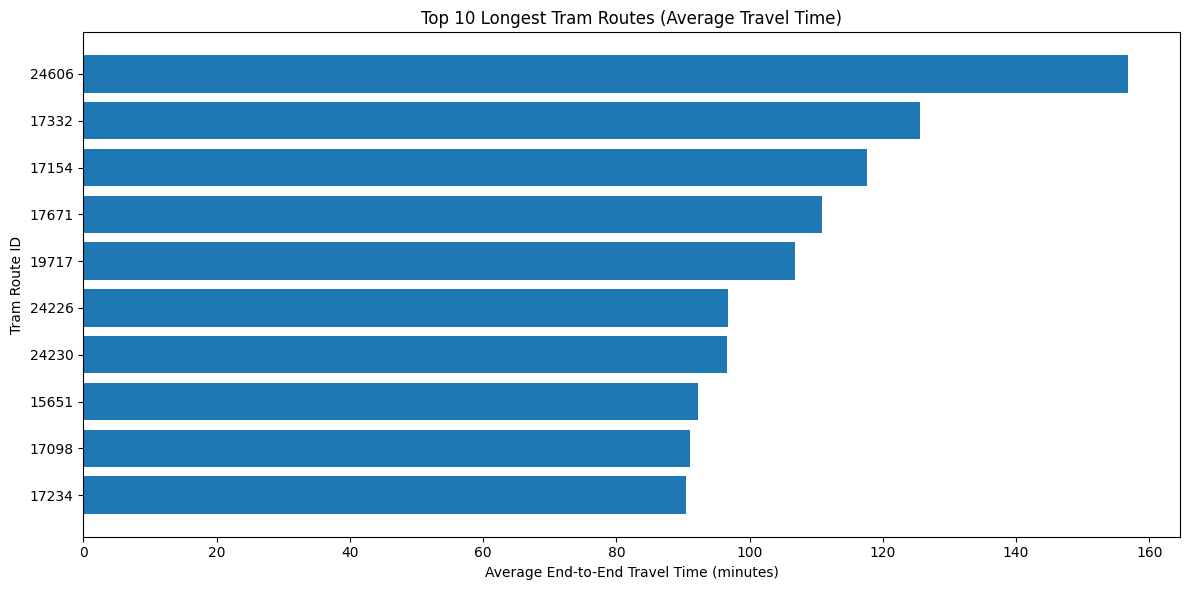

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(
    top10_longest["route_id"].astype(str),
    top10_longest["avg_travel_time_min"]
)

plt.xlabel("Average End-to-End Travel Time (minutes)")
plt.ylabel("Tram Route ID")
plt.title("Top 10 Longest Tram Routes (Average Travel Time)")
plt.gca().invert_yaxis()  # longest at the top
plt.tight_layout()
plt.show()

From this figure, we know that the longest tram route is `24606` whose average end-to-end travel time is around 160 min.

#### Calculate the average hourly touch-on counts for these routes
Extract the hour information in the same way as described in Step 3.

Prepare the dataset, ensure all hours 0-23 are present for each route

In [21]:
# Ensure all hours 0–23 are present for each route
routes = avg_hourly_route["route_id"].unique()
all_hours = pd.MultiIndex.from_product([routes, range(24)], names=["route_id", "hour"])
avg_hourly_route = (
    pd.DataFrame(index=all_hours)
    .reset_index()
    .merge(avg_hourly_route, on=["route_id", "hour"], how="left")
)
avg_hourly_route["avg_touch_ons"] = avg_hourly_route["avg_touch_ons"].fillna(0)

Use a line chart to show the average touch-ons per hour for each tram route.

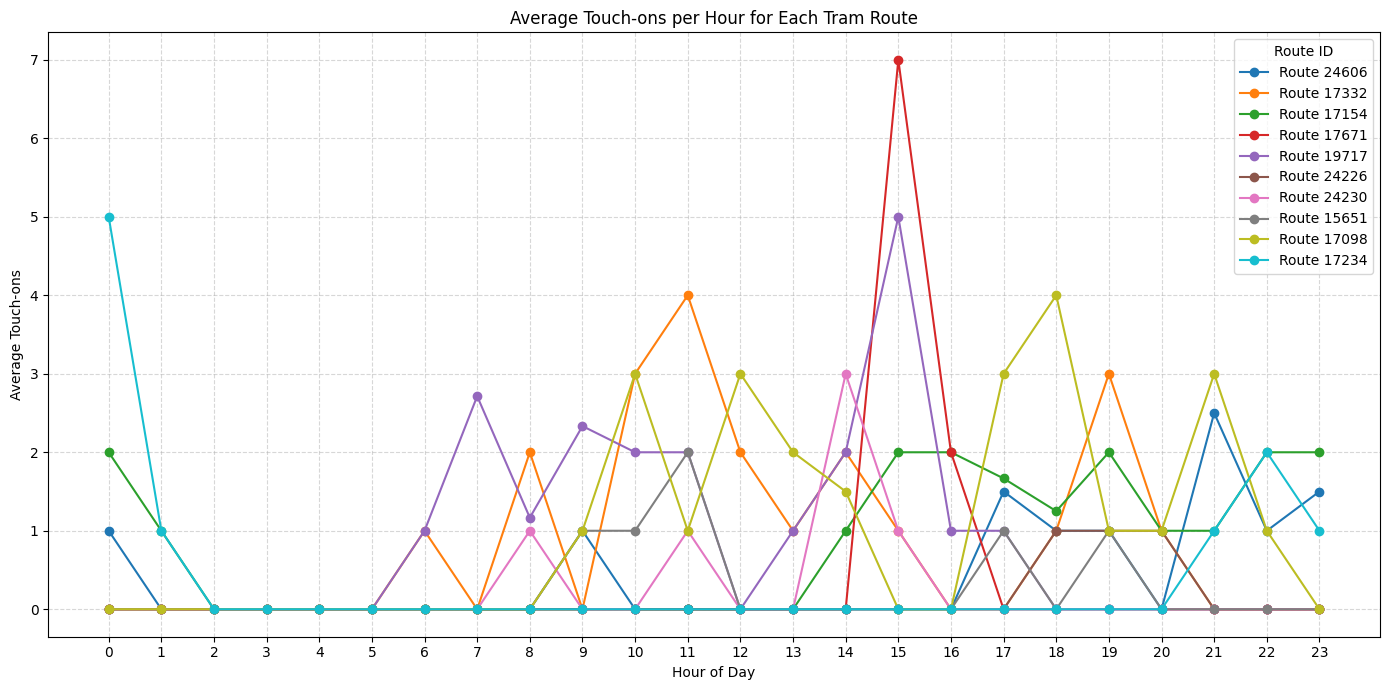

In [22]:
plt.figure(figsize=(14, 7))

for route in top10_longest["route_id"]:
    subset = avg_hourly_route[avg_hourly_route["route_id"] == route]
    plt.plot(subset["hour"], subset["avg_touch_ons"], marker="o", label=f"Route {route}")

plt.xlabel("Hour of Day")
plt.ylabel("Average Touch-ons")
plt.title("Average Touch-ons per Hour for Each Tram Route")
plt.xticks(range(0, 24))
plt.legend(title="Route ID")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

From this figure, we can see that there are no apparent peak windows in either the morning or the afternoon. Therefore, it is not possible to calculate the daily average touch-ons based on morning and afternoon peak windows; instead, we can calculate the daily average touch-ons based on the entire day.

#### Compute the average number of touch-ons

In [23]:
avg_daily = (
    hourly_counts.groupby(["route_id"])["touch_on_count"]
    .mean()
    .reset_index(name="avg_daily_touch_ons")
)

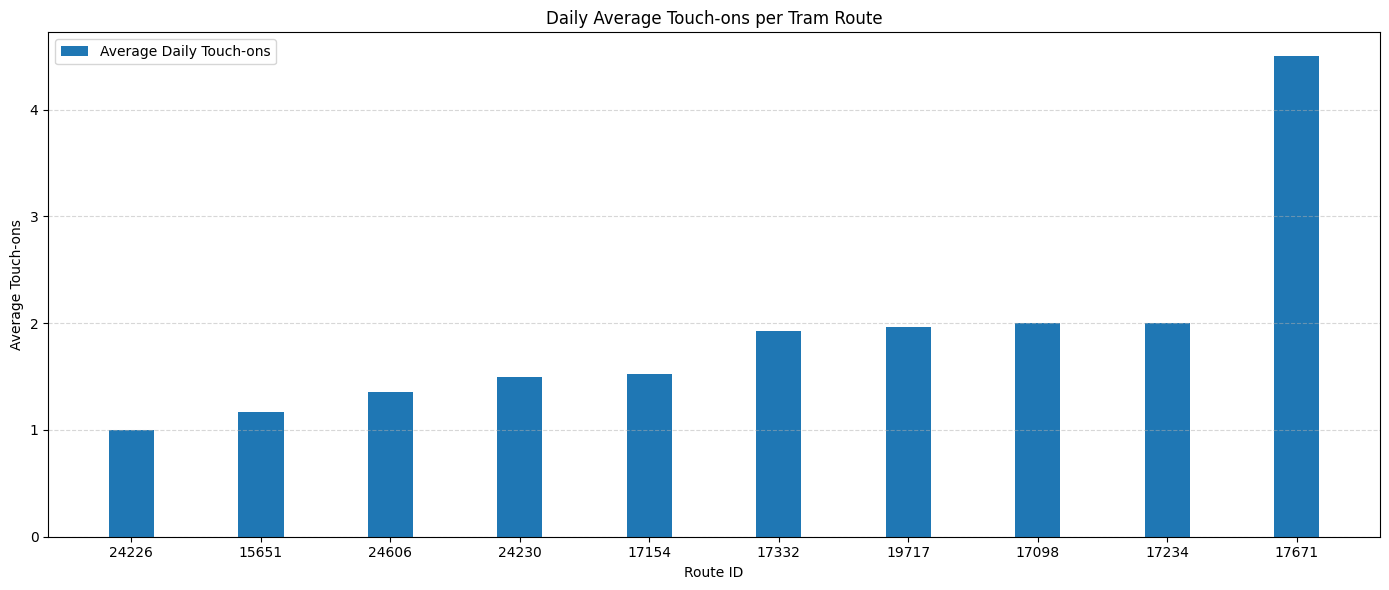

In [24]:
import numpy as np

plot_data = avg_daily[avg_daily["route_id"].isin(top10_longest["route_id"])]
plot_data = plot_data.sort_values("avg_daily_touch_ons")

routes = plot_data["route_id"].astype(str).values
x = np.arange(len(routes))

width = 0.35
plt.figure(figsize=(14, 6))

# average daily difference
plt.bar(
    x,
    plot_data["avg_daily_touch_ons"],
    width,
    label="Average Daily Touch-ons",
)

plt.xticks(x, routes)
plt.xlabel("Route ID")
plt.ylabel("Average Touch-ons")
plt.title("Daily Average Touch-ons per Tram Route")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

From this figure, we can see that the longest tram route, `17671`, has a highest daily average of approximately 4.5 touch-ons.

## Conclusion
The analysis identifies the top 10 busiest stops, the busiest tram routes, and the longest routes based on average end-to-end travel time. From the results, we can see that the busiest trams are those that experience high demand in the morning or afternoon, which aligns with typical commuter peak hours. Additionally, the longest tram routes have an average of approximately 2 touch-ons.

[route-guides](https://yarratrams.com.au/route-guides)
[google maps](https://www.google.com/maps)